In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
from scipy import signal
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

### WKB-weighted vertical velocity variance
* The standard deviation of vertical velocity (variance) increases with depth almost everywhere because stratification is weaker with depth.
* To eliminate this effect w can be weighted by $(N(z)/N_0)^{1/2}$, where $N(z)$ is the mean buoyancy frequency averaged over the ocean area at ech depth and $N_0$ is the mean N averaged over the whole volume of the ocean (von Storch, 2010; Althaus et al., 2003).
$$w^*=w \Big(\frac{N(z)}{N_0}\Big)^{1/2}$$
* With this we can get 2D maps of $w^*$ variance at different depths and profiles of area-averaged $w^*$ at different locations (e.g. just outside the bay vs SCB).

In [78]:
def calc_rho(ds, tt, tAlpha=2.E-4, sBeta=7.4E-4, rhoNil=999.8):
    '''calculate density rho as rho = rhoRef + rho_anom at time tt'''
    Tref = np.squeeze(ds['THETA'][0,...])
    Sref = np.squeeze(ds['SALT'][0,...])
    rhoRef=np.expand_dims(np.expand_dims(ds['rhoRef'][:],1),1)+np.zeros_like(Tref)
    rho = rhoRef + rhoNil*np.ones_like(Tref)*(sBeta*(ds['SALT'][tt,...]-Sref)-
                                              tAlpha*(ds['THETA'][tt,...]-Tref))
    return(rho)

def calc_N2(Z, rho, rhoNil=999.8, g=9.81):
    Zexp = np.expand_dims(np.expand_dims(Z,1),1)+np.zeros_like(rho)
    N2 = -(g/rhoNil)*(rho.data[2:,...]-rho.data[:-2,...])/(Zexp[2:,...]-Zexp[:-2,...])
    return(N2)

def plot_6panels(fld1,fld2,fld3,fld4,fld5,fld6, vmin, vmax,cmap, units,fldname):
    fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3,figsize=(12,9), sharey=True, sharex=True)
    ax0.set_facecolor('tan')
    ax1.set_facecolor('tan')
    ax2.set_facecolor('tan')
    ax3.set_facecolor('tan')
    ax4.set_facecolor('tan')
    ax5.set_facecolor('tan')

    pc = ax0.pcolormesh(lon,lat, np.ma.masked_array(fld1,mask=mask[zz,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax0.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax1.pcolormesh(lon,lat, np.ma.masked_array(fld2,mask=mask[zz2,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.contour(lon,lat,depth, levels=[0,500], colors=['k','0.5'])

    pc = ax2.pcolormesh(lon,lat, np.ma.masked_array(fld3,mask=mask[zz3,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax2.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax3.pcolormesh(lon,lat, np.ma.masked_array(fld4,mask=mask[zz4,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax3.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax4.pcolormesh(lon,lat, np.ma.masked_array(fld5,mask=mask[zz5,:,:]),
                      cmap=cmap, vmin=vmin, vmax=vmax)
    ax4.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    pc = ax5.pcolormesh(lon,lat, np.ma.masked_array(fld6,mask=mask[zz6,:,:]),
                      cmap=cmap,vmin=vmin, vmax=vmax)
    ax5.contour(lon,lat,depth, levels=[0,500], colors=['k', '0.5'])

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.91, 0.125, 0.022, 0.755])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical',label=units)

    ax3.set_xlabel('lon')
    ax4.set_xlabel('lon')
    ax5.set_xlabel('lon')
    ax0.set_ylabel('lat')
    ax3.set_ylabel('lat')

    ax0.set_title(r'%s at %1.1f m'%(fldname,Zl[zz]))
    ax1.set_title('%1.1f m'%(Zl[zz2]))
    ax2.set_title('%1.1f m'%(Zl[zz3]))
    ax3.set_title('%1.1f m'%(Zl[zz4]))
    ax4.set_title('%1.1f m'%(Zl[zz5]))
    ax5.set_title('%1.1f m'%(Zl[zz6]))

    for ax in [ax0,ax1,ax2,ax3,ax4,ax5]:
        ax.set_aspect(1)
        ax.set_ylim(27,35)
        ax.set_xlim(-121,-114)
    return(ax0,ax1,ax2,ax3,ax4,ax5)

In [3]:
outdir = '/data/SO2/sio-kramosmusalem/04_feb_TSref_output/'
levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)

In [4]:
depth = ds.Depth[:]
LAT = ds['YC'][:]
LON = ds['XC'][:]-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

Z = ds['Z'][:]
Zl = ds['Zl'][:]

nx = len(lon)
ny = len(lat)
nz = len(Z)

# centers mask
hFacC = ds['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

rA = ds['rA'][:]
drF = ds['drF'][:]

In [6]:
Tref = np.squeeze(ds['THETA'][0,...])
Sref = np.squeeze(ds['SALT'][0,...])
tAlpha=2.E-4
sBeta=7.4E-4
rhoNil=999.8
rhoRef=np.expand_dims(np.expand_dims(ds['rhoRef'][:],1),1)+np.zeros_like(Tref)

In [7]:
# This cell is very slow
N = np.zeros((nz-2,ny,nx))

ts = 144 # 144=1 day
for tt in range(ts):
    rho = calc_rho(ds,tt)
    N = N + np.sqrt(calc_N2(Z,rho))
    if tt%10==0:
        print(tt)

N = N/ts # mean N (temporal)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [8]:
rA_exp = np.expand_dims(rA[:,:],0)
drF_exp = np.expand_dims(np.expand_dims(drF[:],1),1)
rA_exp = rA_exp + np.zeros(hFacC[:,:,:].shape)
drF_exp = drF_exp + np.zeros(hFacC[:,:,:].shape)
volumes = hFacC[:,:,:]*drF_exp*rA_exp

In [10]:
# Slow cell
N_vol = (np.nansum(np.nansum(np.nansum(N*volumes[1:-1,...], axis=0),axis=0),axis=0)/
         np.nansum(np.nansum(np.nansum(volumes[1:-1,...], axis=0),axis=0),axis=0))

N_area = (np.nansum(np.nansum(N*rA_exp[1:-1,...],axis=1),axis=1)/
          np.nansum(np.nansum(rA_exp[1:-1,...],axis=1),axis=1))

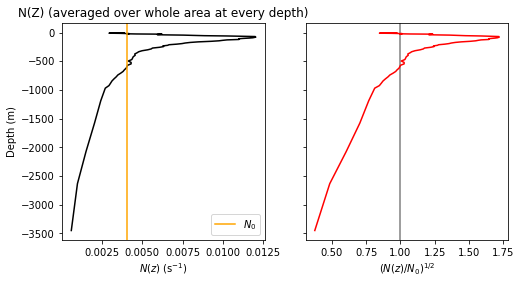

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax1.plot(N_area,Z[1:-1], 'k')
ax1.set_xlabel(r'$N(z)$ (s$^{-1}$)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('N(Z) (averaged over whole area at every depth)')
ax1.axvline(N_vol, color='orange', label='$N_0$')
ax1.legend()
ax2.axvline(1, color='0.5')
ax2.plot(np.sqrt(N_area/N_vol),Z[1:-1], 'r')
ax2.set_xlabel(r'$(N(z)/N_0)^{1/2}$')
plt.show()

In [13]:
N_area_exp = np.expand_dims(np.expand_dims(N_area,1),1)
N_area_exp = N_area_exp + np.zeros_like(N)

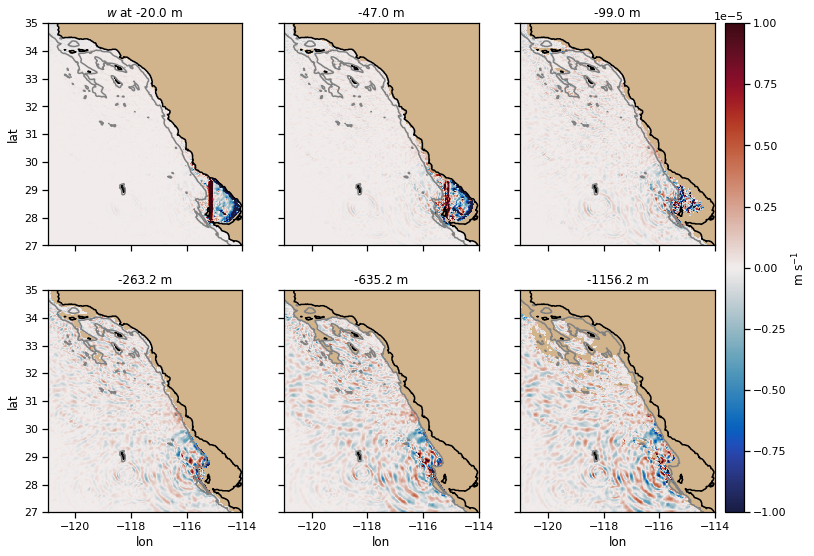

In [79]:
sns.set_context('notebook')
zz = 8
zz2 =15
zz3 = 25
zz4 = 43
zz5 = 60
zz6 = 70
tini = 24
dt = 600

W1 = ds['WVEL'][143,zz,:,:]
W2 = ds['WVEL'][143,zz2,:,:]
W3 = ds['WVEL'][143,zz3,:,:]
W4 = ds['WVEL'][143,zz4,:,:]
W5 = ds['WVEL'][143,zz5,:,:]
W6 = ds['WVEL'][143,zz6,:,:]

ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(W1,W2,W3,W4,W5,W6,-1E-5,1E-5,cmo.cm.balance,'m s$^{-1}$','$w$')

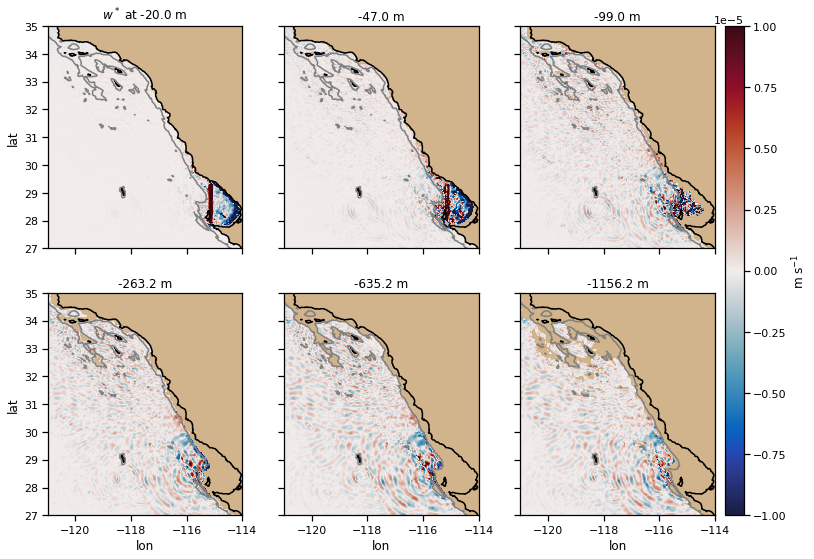

In [80]:
W1b = W1.data*np.sqrt(N_area_exp[zz-1]/N_vol)
W2b = W2.data*np.sqrt(N_area_exp[zz2-1]/N_vol)
W3b = W3.data*np.sqrt(N_area_exp[zz3-1]/N_vol)
W4b = W4.data*np.sqrt(N_area_exp[zz4-1]/N_vol)
W5b = W5.data*np.sqrt(N_area_exp[zz5-1]/N_vol)
W6b = W6.data*np.sqrt(N_area_exp[zz6-1]/N_vol)

ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(W1b,W2b,W3b,W4b,W5b,W6b,-1E-5,1E-5,cmo.cm.balance,'m s$^{-1}$','$w^*$')

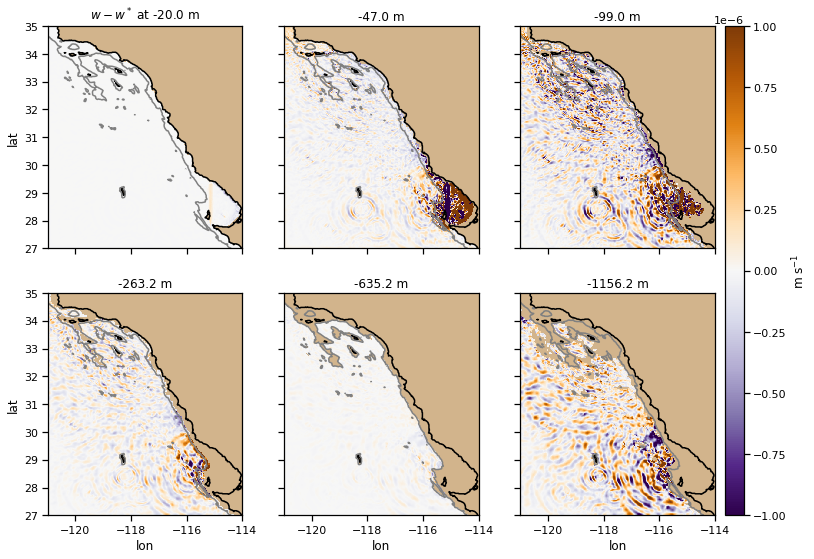

In [81]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(W1-W1b,W2-W2b,W3-W3b,W4-W4b,W5-W5b,W6-W6b,
                                       -1E-6,1E-6,'PuOr_r','m s$^{-1}$','$w-w^*$')

There is less difference between w and w* at 635 m and 20 m depth because that's close to the depths where the weight is 1. Larger correction at 99 m, in tha Bay and smallest one near the surface.

In [82]:
tini = 24
tend = 144

W1 = ds['WVEL'][tini:tend,zz,:,:]
W2 = ds['WVEL'][tini:tend,zz2,:,:]
W3 = ds['WVEL'][tini:tend,zz3,:,:]
W4 = ds['WVEL'][tini:tend,zz4,:,:]
W5 = ds['WVEL'][tini:tend,zz5,:,:]
W6 = ds['WVEL'][tini:tend,zz6,:,:]

W1b = W1.data*np.sqrt(N_area_exp[zz-1]/N_vol)
W2b = W2.data*np.sqrt(N_area_exp[zz2-1]/N_vol)
W3b = W3.data*np.sqrt(N_area_exp[zz3-1]/N_vol)
W4b = W4.data*np.sqrt(N_area_exp[zz4-1]/N_vol)
W5b = W5.data*np.sqrt(N_area_exp[zz5-1]/N_vol)
W6b = W6.data*np.sqrt(N_area_exp[zz6-1]/N_vol)

In [83]:
Var1 = (np.sum(W1*W1, axis=0)*(dt))/(time[tend]-time[tini])
Var2 = (np.sum(W2*W2, axis=0)*(dt))/(time[tend]-time[tini])
Var3 = (np.sum(W3*W3, axis=0)*(dt))/(time[tend]-time[tini])
Var4 = (np.sum(W4*W4, axis=0)*(dt))/(time[tend]-time[tini])
Var5 = (np.sum(W5*W5, axis=0)*(dt))/(time[tend]-time[tini])
Var6 = (np.sum(W6*W6, axis=0)*(dt))/(time[tend]-time[tini])

Var1b = (np.sum(W1b*W1b, axis=0)*(dt))/(time[tend]-time[tini])
Var2b = (np.sum(W2b*W2b, axis=0)*(dt))/(time[tend]-time[tini])
Var3b = (np.sum(W3b*W3b, axis=0)*(dt))/(time[tend]-time[tini])
Var4b = (np.sum(W4b*W4b, axis=0)*(dt))/(time[tend]-time[tini])
Var5b = (np.sum(W5b*W5b, axis=0)*(dt))/(time[tend]-time[tini])
Var6b = (np.sum(W6b*W6b, axis=0)*(dt))/(time[tend]-time[tini])

In [84]:
Std1 = np.std(W1, axis=0)
Std2 = np.std(W2, axis=0)
Std3 = np.std(W3, axis=0)
Std4 = np.std(W4, axis=0)
Std5 = np.std(W5, axis=0)
Std6 = np.std(W6, axis=0)

Std1b = np.std(W1b, axis=0)
Std2b = np.std(W2b, axis=0)
Std3b = np.std(W3b, axis=0)
Std4b = np.std(W4b, axis=0)
Std5b = np.std(W5b, axis=0)
Std6b = np.std(W6b, axis=0)

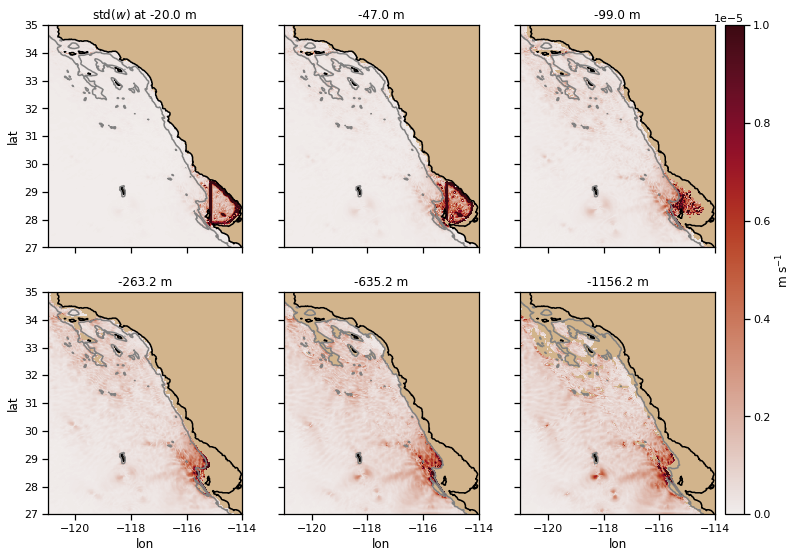

In [87]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1,Std2,Std3,Std4,Std5,Std6,
                                       0,1E-5,cmo.cm.amp,'m s$^{-1}$','std($w$)')

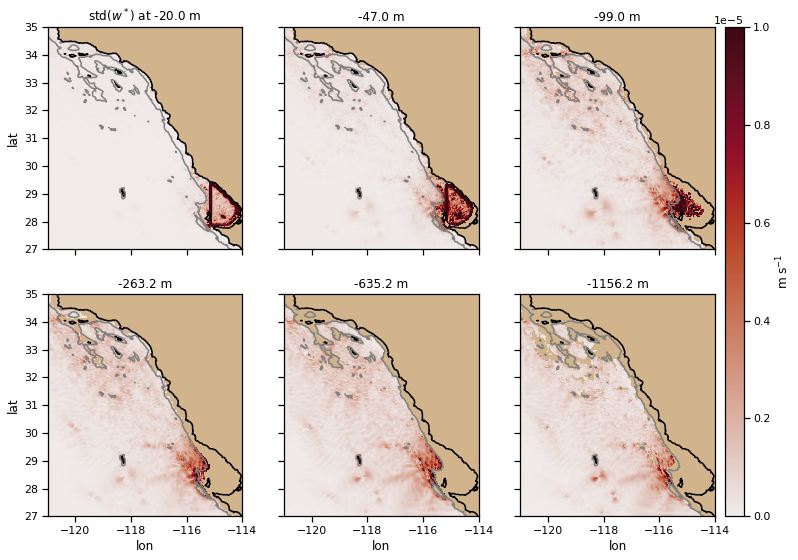

In [88]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1b,Std2b,Std3b,Std4b,Std5b,Std6b,
                                       0,1E-5,cmo.cm.amp,'m s$^{-1}$','std($w^*$)')

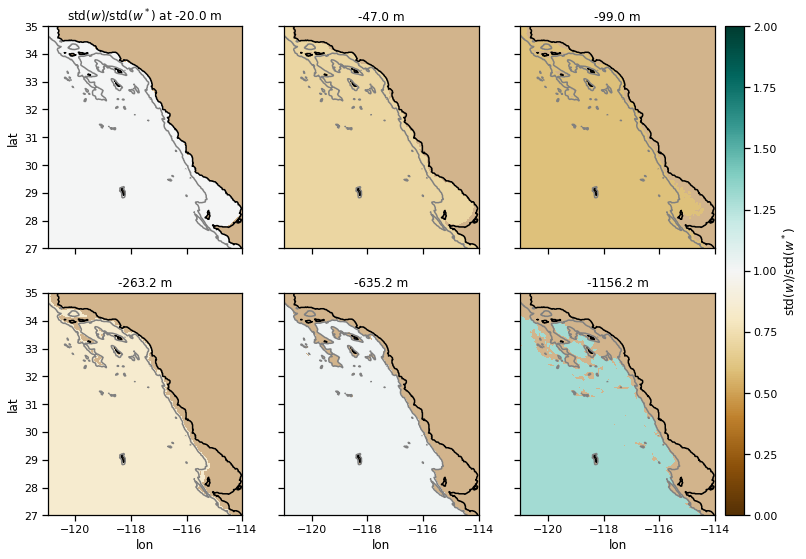

In [89]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Std1/Std1b,Std2/Std2b,Std3/Std3b,Std4/Std4b,Std5/Std5b,Std6/Std6b,
                                       0,2,'BrBG','std($w$)/std($w^*$)','std($w$)/std($w^*$)')

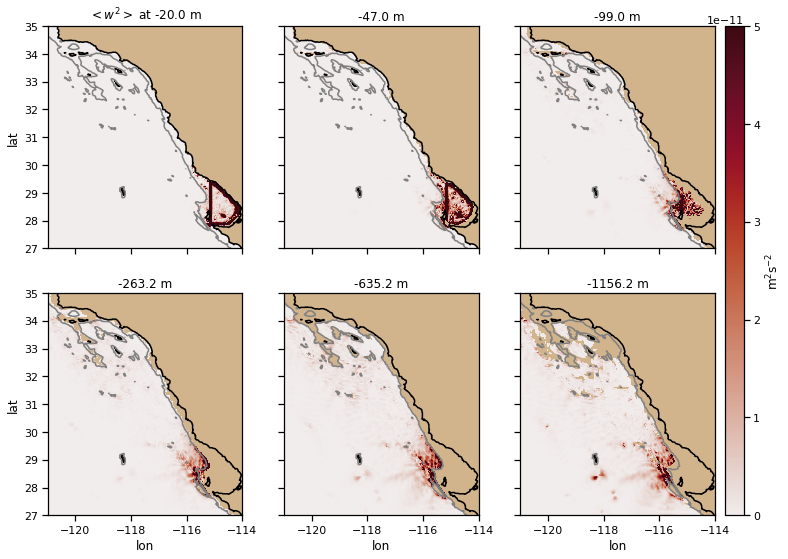

In [102]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1,Var2,Var3,Var4,Var5,Var6,
                                       0,5E-11,cmo.cm.amp,'m$^2$s$^{-2}$','$<w^2>$')

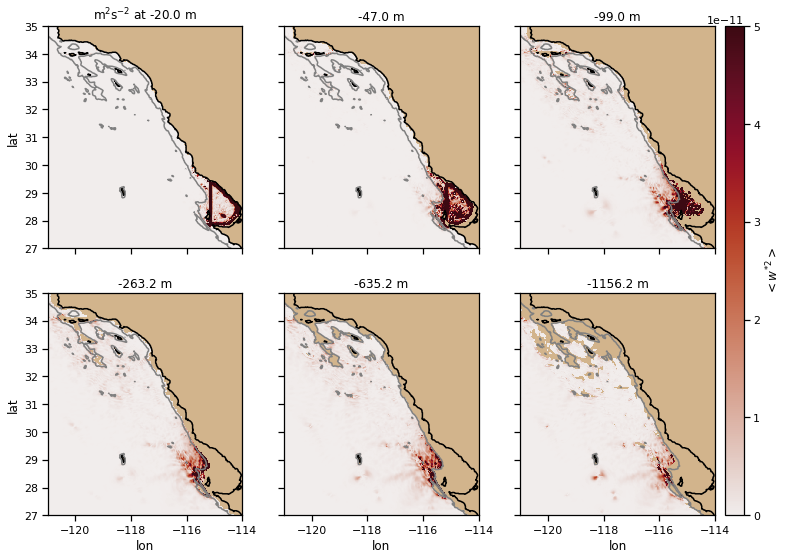

In [107]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1b,Var2b,Var3b,Var4b,Var5b,Var6b,
                                       0,5E-11,cmo.cm.amp,'$<w^{*2}>$','m$^2$s$^{-2}$')

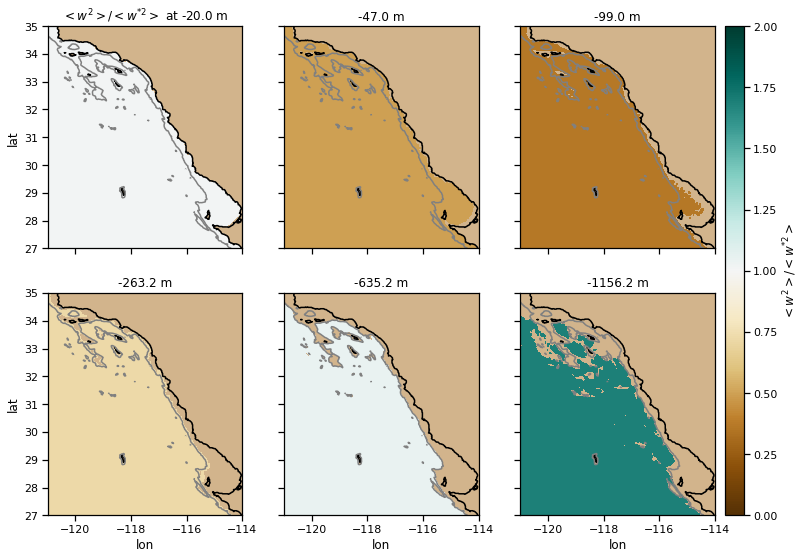

In [108]:
ax0,ax1,ax2,ax3,ax4,ax5 = plot_6panels(Var1/Var1b,Var2/Var2b,Var3/Var3b,Var4/Var4b,Var5/Var5b,Var6/Var6b,
                                       0,2,'BrBG','$<w^{2}>/<w^{*2}>$','$<w^{2}>/<w^{*2}>$')